In [2]:
import numpy as np
import multiprocessing
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from gensim.models import Word2Vec, FastText, KeyedVectors, fasttext, word2vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, AutoModel
import torch

## Считаем данные

In [29]:
news=pd.read_csv('news.csv')
news.columns

Index(['Unnamed: 0', 'header', 'date', 'news'], dtype='object')

In [30]:
news=news.drop(['Unnamed: 0'],axis=1)

In [34]:
news.values[1]

array(['\nВ ОКДЦ пройдет школа для пациентов «Профилактика остеоартроза» \n',
       '\n14:03, 21 мая 2019 г.        ',
       'В среду, 22 мая в 12.00 в ОКДЦ по адресу: Пушкинская, 127, врач-ревматолог первой категории Ольга Агуреева проведет школу для пациентов «Профилактика остеоартроза».Остеоартроз - распространённая форма заболевания суставов, причина которого - поражение хрящевой ткани суставных поверхностей. Симптомы заболевания: боли или неприятные ощущения в суставах и снижение их подвижности, которые мешают заниматься привычными делами. Факторы риска остеоартроза - наследственная предрасположенность и избыточная масса тела.Очень важно как можно раньше поставить диагноз и назначить необходимую терапию.Как предупреждать эту болезнь и бороться с ней, расскажет доктор Ольга Агуреева на бесплатном занятии в ОКДЦ.В арсенале врачей ОКДЦ – все современные методы диагностики: рентгенография, УЗИ суставов, компьютерная и магнитно-резонансная томография, электрокардиография, электромиог

In [38]:
text=news.values[:,2]
text[1]

'В среду, 22 мая в 12.00 в ОКДЦ по адресу: Пушкинская, 127, врач-ревматолог первой категории Ольга Агуреева проведет школу для пациентов «Профилактика остеоартроза».Остеоартроз - распространённая форма заболевания суставов, причина которого - поражение хрящевой ткани суставных поверхностей. Симптомы заболевания: боли или неприятные ощущения в суставах и снижение их подвижности, которые мешают заниматься привычными делами. Факторы риска остеоартроза - наследственная предрасположенность и избыточная масса тела.Очень важно как можно раньше поставить диагноз и назначить необходимую терапию.Как предупреждать эту болезнь и бороться с ней, расскажет доктор Ольга Агуреева на бесплатном занятии в ОКДЦ.В арсенале врачей ОКДЦ – все современные методы диагностики: рентгенография, УЗИ суставов, компьютерная и магнитно-резонансная томография, электрокардиография, электромиография и другие.'

## Проведем токенизацию

In [43]:
def processText(data):
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(line,filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [45]:
tokens=processText(text)
print(tokens[1])

['в', 'среду', '22', 'мая', 'в', '12', '00', 'в', 'окдц', 'по', 'адресу', 'пушкинская', '127', 'врач', 'ревматолог', 'первой', 'категории', 'ольга', 'агуреева', 'проведет', 'школу', 'для', 'пациентов', '«профилактика', 'остеоартроза»', 'остеоартроз', 'распространённая', 'форма', 'заболевания', 'суставов', 'причина', 'которого', 'поражение', 'хрящевой', 'ткани', 'суставных', 'поверхностей', 'симптомы', 'заболевания', 'боли', 'или', 'неприятные', 'ощущения', 'в', 'суставах', 'и', 'снижение', 'их', 'подвижности', 'которые', 'мешают', 'заниматься', 'привычными', 'делами', 'факторы', 'риска', 'остеоартроза', 'наследственная', 'предрасположенность', 'и', 'избыточная', 'масса', 'тела', 'очень', 'важно', 'как', 'можно', 'раньше', 'поставить', 'диагноз', 'и', 'назначить', 'необходимую', 'терапию', 'как', 'предупреждать', 'эту', 'болезнь', 'и', 'бороться', 'с', 'ней', 'расскажет', 'доктор', 'ольга', 'агуреева', 'на', 'бесплатном', 'занятии', 'в', 'окдц', 'в', 'арсенале', 'врачей', 'окдц', '–', '

## Обучим на нашем корпусе модель word2vec

In [50]:
cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count=1,
                     window=5,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-2)

w2v_model.build_vocab(tokens, progress_per=10000) # загрузка словаря

Для векторизации используется алгоритм skip-gram

In [52]:
t = time()
w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=400, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.save("news_word2vec.model")

Time to train the model: 2.01 mins


In [68]:
#w2v_model = Word2Vec.load("weights/word2vec.model")

In [64]:
w2v_model.wv.most_similar('убийство')

[('«расследование', 0.45152929425239563),
 ('яне', 0.4470641314983368),
 ('покушение', 0.43443429470062256),
 ('случайного', 0.42635226249694824),
 ('«29', 0.41899344325065613),
 ('бандитизм', 0.4089791476726532),
 ('соверши\xa0', 0.40599653124809265),
 ('покушении', 0.4059793949127197),
 ('слушалось', 0.38803744316101074),
 ('самообороной', 0.38268062472343445)]

# Считаем готовые модели

Веса можно скачать вот тут https://rusvectores.org/ru/models/

## Fasttext

In [3]:
 # Обрабатывает ТОЛЬКО по одному слову

ft_path='weights/geowac_lemmas_none_fasttextskipgram_300_5_2020'
ft_model = fasttext.FastTextKeyedVectors.load(ft_path)

## Word2vec

In [8]:
# Обрабатывает ТОЛЬКО по одному слову

w2v_model=KeyedVectors.load_word2vec_format('weights/araneum_upos_skipgram_300_2_2018.vec.gz')
w2v_model.most_similar('телефон_NOUN')

[('мобильник_NOUN', 0.7253797650337219),
 ('телефончик_NOUN', 0.6618183851242065),
 ('тлф_X', 0.6574768424034119),
 ('мобилка_NOUN', 0.6435704827308655),
 ('звонить_VERB', 0.6251471042633057),
 ('позвонить_VERB', 0.6051713228225708),
 ('факс_NOUN', 0.6026340126991272),
 ('автоответчик_NOUN', 0.6012487411499023),
 ('сотик_NOUN', 0.5854730606079102),
 ('сотовый_ADJ', 0.5771450996398926)]

## Sbert

https://huggingface.co/sberbank-ai/sbert_large_mt_nlu_ru

In [ ]:
# Обрабатывает по всему предложению или абзацу

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask
#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)
#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

## Визуализация векторов слов

In [71]:
def tsnescatterplot(model, word, list_names):
   
   # инициализируем массив слов для вывода 
    arrays = np.empty((0, 300), dtype='f')

    word_labels = [word]
    color_list  = ['red']
    
    # добавим вектор опорного слова в массив вывода
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # найдем наиболее похожие слова по отношению к опорному
    close_words = model.wv.most_similar([word])
    
    # добавим вектора похожих слов в массив вывода
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # добавим вектора интересующих слов в массив вывода
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # с помощью метода главных компонент уменьшим размероность массива вывода
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    
    # сделаем вывод чисел с плав. зап. как вывод чисел с фикс. зап.
    np.set_printoptions(suppress=True)
    
    # получим умную 2-х мерную матрицу вывода из 12-ти мерной
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # создадим дф для вывода
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    N=15
    fig, _ = plt.subplots(figsize=(N,N))

    
    # проставляем точки
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # проставляем сами слова
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

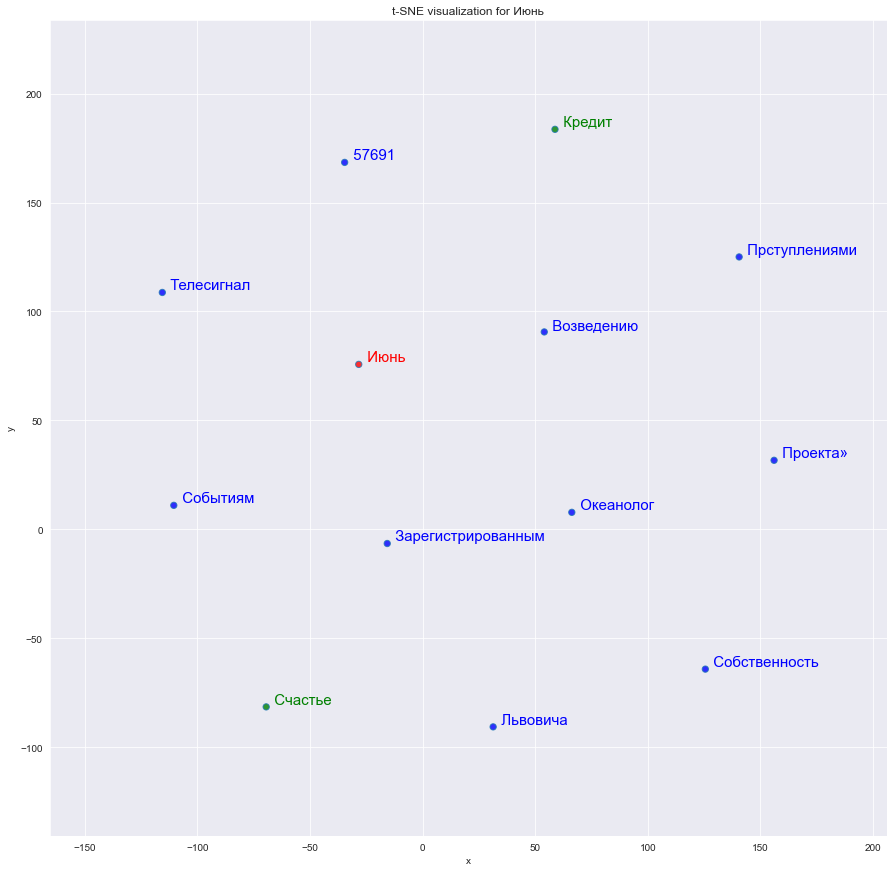

In [72]:
tsnescatterplot(w2v_model, 'июнь', ['кредит','счастье'])